# Patlak Model

In [1]:
# import statements
import os
import numpy as np
from matplotlib import pyplot as plt
import csv
import pandas as pd
import seaborn as sns
from plotting_results_nb import plot_bland_altman, bland_altman_statistics
import json
from pathlib import Path

## Background
some background on the method if necessary

## Test data

Data summary: simulated Patlak model data

Source: Concentration-time data (n = 9) generated by M. Thrippleton using Matlab code at https://github.com/mjt320/DCE-functions

Detailed info:
- Temporal resolution: 0.5 s
- Acquisition time: 300 s
- AIF: Parker function, starting at t=10s
- Noise: SD = 0.02 mM
- Arterial delay: none
 
Reference values: Reference values are the parameters used to generate the data. All combinations of $v_p$ (0.1, 0.2, 0.5) and PS (0, 5, 15)*1e-2 per min are included.

Citation: Code used in Manning et al., Magnetic Resonance in Medicine, 2021 https://doi.org/10.1002/mrm.28833 and Matlab code: https://github.com/mjt320/DCE-functions

Tolerances
- $v_p$: a_tol=0.0025, r_tol=0, start=0.01, bounds=(0,1)
- PS: a_tol=0.005, r_tol=0.01, start=0.6, bounds=(0,5), units [/min]


### Visualize test data
showing the data from high SNR from the original DRO and lowest SNR of 20

(array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 432x288 with 0 Axes>

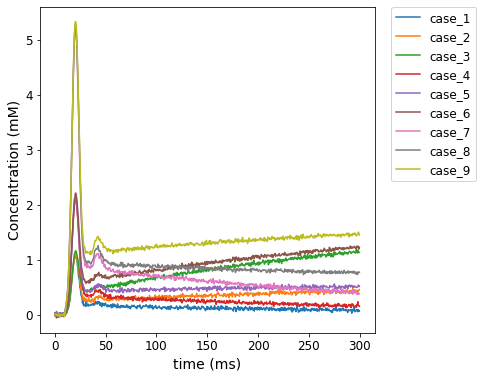

In [2]:
#plot test data
filename = ('../test/DCEmodels/data/patlak_sd_0.02_delay_0.csv')
# read from CSV to pandas
df1 = pd.read_csv(filename)

no_voxels = len(df1.label)

plt.figure()
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(6,6))
for currentvoxel in range(no_voxels):
    labelname = 'case_' + str(currentvoxel+1)
    testdata = df1[(df1['label']==labelname)]
    t = testdata['t'].to_numpy()
    t = np.fromstring(t[0], dtype=float, sep=' ')
    c = testdata['C_t'].to_numpy()
    c = np.fromstring(c[0], dtype=float, sep=' ')
    ax.plot(t, c, label=labelname)
    
ax.set_ylabel('Concentration (mM)', fontsize=14)
ax.set_xlabel('time (ms)', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0,fontsize=12)   
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

    

## Import data

In [3]:
# Load the meta data
meta = json.load(open("../test/results/results-meta.json"))

In [4]:
# Loop over each entry and collect the dataframe
df = []
for entry in meta:
    if (entry['category'] == 'DCEmodels') & (entry['method'] == 'patlak') :
        fpath, fname, category, method, author = entry.values()
        df_entry = pd.read_csv(Path(fpath, fname)).assign(author=author)
        df.append(df_entry)
    
# Concat all entries
df = pd.concat(df)

In [5]:
author_list = df.author.unique()
no_authors = len(author_list)

# calculate error between measured and reference values
df['error_ps'] = df['ps_meas'] - df['ps_ref']
df['error_vp'] = df['vp_meas']- df['vp_ref']

# tolerances
tolerances = { 'ps': {'atol' : 0.005, 'rtol': 0.01 }, 'vp': {'atol':0.0025, 'rtol':0}}

## Results

<Figure size 432x288 with 0 Axes>

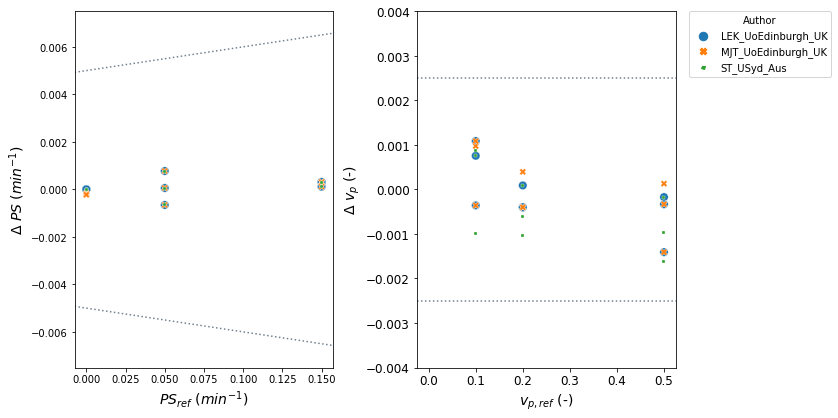

In [6]:
plt.figure()
fig, ax = plt.subplots(1,2, sharey='none', figsize=(10,6))
plot_bland_altman(ax[0], df, tolerances, 'ps', ylim=(-0.0075,0.0075),label_xaxis='$PS_{ref}$ ($min^{-1}$)',label_yaxis='$\Delta$ $PS$ ($min^{-1}$)')

plot_bland_altman(ax[1], df, tolerances, 'vp', ylim=(-0.004,0.004),label_xaxis='$v_{p,ref}$ (-)',label_yaxis='$\Delta$ $v_{p}$ (-)')
fig.tight_layout()
fig.subplots_adjust(left=0.15, top=0.95)

# Hide the legend for the left subplot
ax[0].get_legend().set_visible(False)
# Set the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), title='Author', loc='upper left', borderaxespad=0)


Bias results estimated PS values combined for all voxels

In [7]:
resultsBA = bland_altman_statistics(data=df,par='error_ps',grouptag='author')
print(resultsBA)

                        bias  std_error  LoA lower  LoA upper
author                                                       
LEK_UoEdinburgh_UK  0.000100   0.000378  -0.000641   0.000840
MJT_UoEdinburgh_UK  0.000031   0.000411  -0.000774   0.000837
ST_USyd_Aus         0.000100   0.000378  -0.000641   0.000840


In [8]:
resultsBA = bland_altman_statistics(data=df,par='error_vp',grouptag='author')
print(resultsBA)

                        bias  std_error  LoA lower  LoA upper
author                                                       
LEK_UoEdinburgh_UK -0.000129   0.000723  -0.001547   0.001289
MJT_UoEdinburgh_UK -0.000037   0.000777  -0.001560   0.001486
ST_USyd_Aus        -0.000407   0.000855  -0.002082   0.001268


## Notes
Additional notes/remarks

### References